In [32]:
from qutip import mesolve, basis, jmat
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator, floquet_modes
import time as time
import matplotlib.pyplot as plt

def floquet_modes_phtr(H, T, args=None, parallel=False, sort=False, U=None):
    if 'opts' in args:
        options = args['opts']
    else:
        options = Options()
        options.rhs_reuse = True
        rhs_clear() 
    
    if U is None:
        U = propagator(H, T, [], args, options=options)
    
    evals, evecs = la.eig(U.full())

    eargs = angle(evals)
    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    new_dims = [U.dims[0], [1] * len(U.dims[0])]
    new_shape = [U.shape[0], 1]
    kets_order = [Qobj(np.matrix(evecs[:, o]).T,
                       dims=new_dims, shape=new_shape) for o in order]

    return kets_order, e_quasi[order]

def drive_exact(t, args):
    w = args['omega']
    h = args['h']
    h0 = args['h0']
    return h * np.cos(w*t) + h0

def get_hamiltonians_exact(args):
    N = args['N']
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/(N-1)                                      # kacNorm
    H0 = kn * sz **2
    H1 = 2 * sx
    return H0,H1

def floq_evolv_exact(args):
    w = args['omega']
    T = 2 * np.pi/w
    H0, H1 = get_hamiltonians_exact(args)
    H = [H0,[H1,drive_exact]]
    f_modes_0, f_energies = floquet_modes(H, T, args=args)
    return f_modes_0, f_energies, w

print('definition done!')

definition done!


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.special import jn_zeros, j0
import math
from qutip import Options
#from functions_needed_phase_study import*
import h5py, time
freezing_pts = jn_zeros(0, 500)
start = time.time()

Ns = [4, 10]

# which number of floquet mode we take
nth = 0       
h0 = np.sqrt(3)/2**4
ws = np.exp(np.linspace(np.log(1), np.log(100), 40))
'''
ws1 = np.exp(np.linspace(np.log(1.0), np.log(5), 10))
ws2 = np.exp(np.linspace(np.log(6,), np.log(15), 30))
ws3 = np.exp(np.linspace(np.log(17.), np.log(100.0), 10))
ws = np.concatenate((ws1, ws3 , ws4))
'''
if __name__ == '__main__':
    nprocs = 2  
    
    for nn,N in enumerate(Ns):
        start1 = time.time()
        opts = Options(nsteps = 1e4)
        params = [{'h0':h0, 'h': 1/4 * w * freezing_pts[0], 'omega':w, 'N':N, 'opts':opts} for w in ws]
        
        p = Pool(processes = nprocs)  
        data = p.map(floq_evolv_exact,params)

        evec_f = np.array([np.array(data[j][0])[:,:,0] for j in range(len(ws))])
        phs_f = np.array([np.array(data[i][1]) for i in range(len(ws))])
        ws = np.array([data[i][2] for i in range(len(ws))])

        evals_single_path = np.zeros(len(ws))
        iprmat_single_path = np.zeros(len(ws))
        iprmat = np.zeros((len(ws),2*N+1))

        sx = jmat(N,"x")
        en, st = sx.eigenstates()

        for xx,w in enumerate(ws):
            #Get the previous Floquet Eigensystem
            if xx == 0:
                evals_prev = phs_f[xx].real
                evecs_prev = evec_f[xx]
            else:
                evals_prev = phs_f[xx-1].real
                evecs_prev = evec_f[xx-1]

            #Sort the Floquet states of this itertaion accordingly to orthonormality with the previous ones
            evals_curr = phs_f[xx]
            evecs_curr = evec_f[xx]
            t = np.copy(evecs_curr)
            condition = np.abs(np.around(evecs_prev.T.conj() @ evecs_curr, 1))
            evals_curr = evals_curr[np.argmax(condition, axis=1)]        
            evecs_curr = evecs_curr[:,np.argmax(condition, axis=1)]

            evals_single_path[xx] = evals_curr[nth]
            f_states = evec_f[xx]
            iprmat[xx,:] = [np.sum([np.abs(Qobj(state).overlap(sx_ev))**4 for sx_ev in st],\
                                   axis=-1) for state in f_states]

            iprmat_single_path[xx] = iprmat[xx,:][nth]
       
        # save the data
        filename = 'phase_transition_11N_check_' + str(N) +'_.hdf5'

        with h5py.File(filename, 'w') as hf:
            hf.create_dataset('ws', np.shape(ws), data=ws)
            hf.create_dataset('evals_single_path', np.shape(evals_single_path), data=evals_single_path)
            hf.create_dataset('iprmat_single_path', np.shape(iprmat_single_path), data=iprmat_single_path)
            hf.attrs['N'] = N
            hf.attrs['nth'] = nth
        
        print("For N = ", N, "with", nprocs, "processors : time taken ", (time.time()-start1)/60, ' minutes !')
    print('\n run complete!! \n\n TOTAL TIME TAKEN :', (time.time()-start)/60, ' minutes !')



print('its working !!')

For N =  4 with 2 processors : time taken  0.03878445227940877  minutes !
For N =  10 with 2 processors : time taken  0.16011041402816772  minutes !

 run complete!! 

 TOTAL TIME TAKEN : 0.1989271879196167  minutes !
its working !!


In [42]:
!ls phase_transition_11N_check_* > file_phasetran.txt
!cat file_phasetran.txt

phase_transition_11N_check_10_.hdf5
phase_transition_11N_check_4_.hdf5


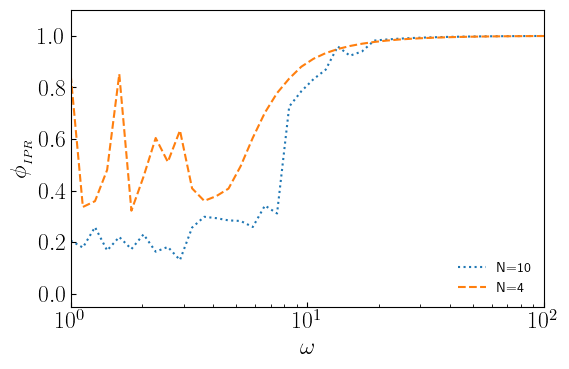

CPU times: user 636 ms, sys: 23.8 ms, total: 660 ms
Wall time: 676 ms


In [43]:
%%time
import matplotlib.pyplot as plt
import h5py

plt.rcParams.update({ "figure.figsize": (6, 4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 17, "font.sans-serif": ["Computer Modern"]})


with open("file_phasetran.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    j =0
    
    linest = ['dotted', 'dashed', 'dashdot','solid']
    for i in range(0,x):
        filename = lines[i][:-1]
        with h5py.File(filename, 'r') as f:    
            ws = f['ws'][()]
            evals_single_path = f['evals_single_path'][()]
            iprmat_single_path = f['iprmat_single_path'][()]
            N = f.attrs['N']
            
            lbl = 'N=' + str(N)
            plt.plot(ws, iprmat_single_path, label = lbl, linestyle= linest[i] )
                
plt.ylabel(r"$\phi_{{_{{IPR}}}}$")
plt.xlabel(r"$\omega$")
plt.ylim(-0.05,1.1)
plt.xlim(1,ws[-1])
plt.xscale('log')

figname= "phase_dynam1.jpeg" 

plt.tick_params(which='both',axis="x", direction="in")
plt.tick_params(axis="y", direction="in")
plt.tight_layout()
plt.legend(frameon = False, loc = 4,fontsize= 10)
#plt.savefig(figname,dpi=600)
plt.show()